# Лабораторная работа 4: Машина опорных векторов (SVM)
## Олохтонова Мария
## НПМ бд-01-19

## 1. Квадратичное программирование и QP-солвер

Квадратичное программирование (QP) — специальный тип задач математической оптимизации, заключающийся в нахождении точки минимума неотрицательно-определенной квадратичной формы (многомерная парабола) в присутствии линейных ограничений:
$$
\begin{gather}
    \frac{1}{2}\boldsymbol x^T\boldsymbol P\boldsymbol x + \boldsymbol q^T\boldsymbol x \to \min_{\boldsymbol x} \\
    \begin{aligned}
        \text{s.t.} \quad & \boldsymbol G\boldsymbol x \le \boldsymbol h \\
        & \boldsymbol A\boldsymbol x = \boldsymbol b
    \end{aligned}
\end{gather}
$$

Здесь $\boldsymbol P$ — симметричная матрица. В ограничениях $\boldsymbol G\boldsymbol x \le \boldsymbol h$ и $\boldsymbol A\boldsymbol x = \boldsymbol b$ под знаками равенства и неравенства подразумевается сравнение всех компонент векторов.

Задача квадратичного программирования хорошо изучена, существуют эффективные алгоритмы для ее решения. Имеется множество библиотек с солверами для задачи QP, вот некоторые из них:
 - [CVXOPT](http://cvxopt.org/) (свободно-распространяемая, Python) **рекомендуется к использованию**
 - [Mosek](https://www.mosek.com/) (коммерческая с возможностью получения академической лицензии, C, Java, MATLAB, .NET, R, Python)
 - [Matlab Optimization Toolbox](http://www.mathworks.com/help/optim/ug/quadprog.html) 

#### Задание

1. Установите QP-солвер, разберитесь с его интерфейсом.
2. Протестируйте солвер, решив простую задачу оптимизации в двумерном пространстве:
$$f(\boldsymbol x) = -8x_1 - 16x_2 + x_1^2 + 4x_2^2, \quad \text{s.t.:} \; x_1 + x_2 \leq 5, \; 0 \leq x_1 \leq 3, \; x_2 \geq 0$$
3. Какие из ограничений-неравенств задачи являются _активными_, т.е. влияют на точку оптимума, а какие ограничения можно выбросить и точка оптимума не поменяется?

In [64]:
%matplotlib inline

from cvxopt import matrix, solvers
import numpy as np
import matplotlib.pyplot as plt
solvers.options['show_progress'] = False

In [2]:
P = matrix(np.array([[2, 0], [0, 8]]), tc='d')
q = matrix(np.array([-8, -16]), tc='d')
G = matrix(np.array([[1, 1], [1, 0], [-1, 0], [0, -1]]), tc='d')
h = matrix(np.array([5, 3, 0, 0]), tc='d')

sol = solvers.qp(P, q, G, h)


In [3]:
print(sol['x'])

[ 3.00e+00]
[ 2.00e+00]



Уберем условие $ x_1 + x_2 \leq 5 $

In [4]:
G1 = matrix(np.array([[1, 0], [-1, 0], [0, -1]]), tc='d')
h1 = matrix(np.array([3, 0, 0]), tc='d')
sol = solvers.qp(P, q, G1, h1)
print(sol['x'])

[ 3.00e+00]
[ 2.00e+00]



Уберем условие $ x_1 \geq 0 $

In [5]:
G2 = matrix(np.array([[1, 1], [1, 0], [0, -1]]), tc='d')
h2 = matrix(np.array([5, 3, 0]), tc='d')
sol = solvers.qp(P, q, G2, h2)
print(sol['x'])

[ 3.00e+00]
[ 2.00e+00]



Уберем условие $ x_1 \leq 3 $

In [6]:
G3 = matrix(np.array([[1, 1], [-1, 0], [0, -1]]), tc='d')
h3 = matrix(np.array([5, 0, 0]), tc='d')
sol = solvers.qp(P, q, G3, h3)
print(sol['x'])

[ 3.20e+00]
[ 1.80e+00]



Уберем условие $ x_2 \geq 0 $

In [7]:
G4 = matrix(np.array([[1, 1], [1, 0], [-1, 0]]), tc='d')
h4 = matrix(np.array([5, 3, 0]), tc='d')
sol = solvers.qp(P, q, G4, h4)
print(sol['x'])

[ 3.00e+00]
[ 2.00e+00]



Из ограничений-неравенств задачи активным является $ x_1 \leq 3 $, а остальные можно отбросить и точка оптимума не поменяется:



In [8]:
G5 = matrix(np.array([[1, 0]]), tc='d')
h5 = matrix(np.array([3]), tc='d')
sol = solvers.qp(P, q, G5, h5)
print(sol['x'])

[ 3.00e+00]
[ 2.00e+00]



## 2. Линейный SVM

Рассмотрим задачу бинарной классификации. Будем обозначать обучающую выборку $\{(\boldsymbol x_n, y_n)\}_{n=1}^N$, где $N$ — количество объектов, $\boldsymbol x_n \in \mathbb{R}^d$ — числовой вектор признакового описания объекта, $y_n \in \{+1, -1\}$ — класс объекта.

Машина опорных векторов обучает модель разделяющей гиперплоскости:
$$f(\boldsymbol x) = \boldsymbol w^T \boldsymbol x + b$$
Параметры модели — вектор весов $\boldsymbol w \in \mathbb{R}^d$ и сдвиг $b \in \mathbb{R}$.

Обучение модели происходит путем решения оптимизационной задачи:
$$
\begin{gather}
    \frac{1}{2} \| \boldsymbol w \|^2 + C \sum_{n=1}^N \xi_n \to \min_{\boldsymbol w, \boldsymbol \xi, b} \\
    \text{s.t.: } \quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1 - \xi_n, \quad \xi_n \geq 0, \quad \forall n=1,\dots,N
\end{gather}
$$

Ограничения вида $\quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1$ требуют, чтобы объекты правильно классифицировались разделяющей гиперплоскостью. Поскольку линейная разделимость выборки не гарантируется на практике, вводят переменные $\xi_n$ (slack variables), которые ослабляют ограничения правильной классификации. В оптимизируемом функционале слагаемое $\| \boldsymbol w \|^2$ штрафует малую ширину разделяющей гиперплоскости, сумма $\sum_n \xi_n$ штрафует ослабление ограничений. 

Гиперпараметр $C$ задает баланс между шириной разделяющей полосы и ошибками, допускаемыми классификатором. Обратите внимание, что $C$ фиксируется до обучения и не оптимизируется вместе с параметрами модели.

Гиперпараметр $C$ отвечает за обобщающую способность разделяющей гиперплоскости, высокая обобщающая способность (соотвествующая большому значению $C$) может привести к переобучению, если линейная модель хорошо описывает обучающие примеры. При подборе оптимального параметра $C$ необходимо оценивать качество на отложенной выборке или кросс-валидации. Как правило, для конкретной задачи заранее неизвестно, какой порядок имеет оптимальное значение гиперпараметра $C$, поэтому перебирать значения лучше по логарифмической сетке, например: $10^{-3}, 10^{-2}, \dots, 10^{5}$.

После нахождения решения оптимизационной задачи $(\boldsymbol w_{\star}, \boldsymbol \xi_{\star}, b_{\star})$, часть ограничений становятся _активными_, т.е. переходят в "крайнее положение" — точное равенство:
$$\quad y_n (\boldsymbol w_{\star}^T \boldsymbol x_n + b_{\star}) = 1 - \xi_{\star,n}$$
Объекты, соответствующие активным ограничениям называются _опорными_.

#### Явное преобразование признаков

Разделяющая гиперплоскость — достаточно грубая модель, редко данные могут быть описаны линейной моделью. Линейная неразделимость векторов может быть исправлена путем перехода в другое признаковое пространство, в котором линейная модель лучше описывает данные и, возможно, существует правильно классифицирующая разделяющая гиперплоскость:

$$\boldsymbol x \in \mathbb{R}^d \mapsto \phi(\boldsymbol x) \in \mathbb{R}^t$$

Так, например, добавление всех попарных произведений признаков: $\phi(x_1, \dots, x_d) = (x_1, \dots, x_d, x_1^2, x_1x_2, \dots, x_d^2)$ переводит в пространство, в котором линейная гиперплоскость является квадратичной формой в исходном пространстве и в исходном пространстве признаков разделяющая поверхность может быть, скажем, эллипсом.

[Видеоролик с демонстрацией](https://youtu.be/9NrALgHFwTo)

#### Задание
  1. Сведите задачу обучения линейного SVM к QP, реализуйте процедуру обучения Линейного SVM при помощи QP-солвера.
  2. Сгенерируйте три случайные двумерные выборки для бинарной классификации:
    - с линейно-разделимыми классами
    - с хорошо разделимыми классами, но не линейно
    - с плохо разделимыми классами по имеющимся признакам
  3. Протестируйте линейный SVM на сгенерированных выборках. Покажите на плоскости разделяющую прямую и линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Постройте классификаторы с различным значением параметра $C$.
  4. Как зависит число опорных векторов от параметра $C$ для различных выборок?
  5. Используя явное преобразование признаков обучите методом опорных векторов квадратичную разделяющую поверхность. Покажите ее на плоскости.

In [65]:
from sklearn.base import BaseEstimator

class LinearSVM(BaseEstimator):
    def __init__(self, C, transform=None):
        self.C = C
        self.transform = transform
    
    def QP(self, X, y): 
        N = X.shape[0]
        dim = X.shape[1]

        P11 = np.eye(dim)
        P12 = np.zeros((dim, N + 1))
        P1 = np.hstack([P11, P12])
        P2 = np.zeros((N + 1, dim + N + 1)) 
        P = matrix(np.vstack([P1, P2]), tc='d')

        q1 = np.zeros(dim + 1)
        q2 = np.array([self.C] * N)
        q = matrix(np.hstack([q1, q2]), tc='d') 

        G11 = -y.reshape((N, 1)) * X
        G12 = -y.reshape((N, 1))
        G13 = -np.eye(N)
        G21 = np.zeros((N, dim))
        G22 = np.zeros((N, 1))
        G23 = -np.eye(N)
        G1 = np.hstack([G11, G12, G13])
        G2 = np.hstack([G21, G22, G23])
        G = matrix(np.vstack([G1, G2]), tc='d')

        h1 = -np.ones(N)
        h2 = np.zeros(N)
        h = matrix(np.hstack([h1, h2]), tc='d')

        sol = solvers.qp(P, q, G, h)    
        W = sol['x'][:dim]  
        b = sol['x'][dim]
        penalty = np.array(sol['x'][dim + 1:])        
    
        return W, b, penalty
    
    def fit(self, X, y):
        if self.transform is not None:
            X = self.transform(X)
                
        N = X.shape[0]
        dim = X.shape[1]        
        W, b, penalty = self.QP(X, y)
        
        self.weights_ = np.array(W).reshape(dim,)
        self.bias_ = b
        self.penalty_ = penalty
        self.support_indices_ = np.array([])
        
        # Найдем опорные элементы (близкие по модулю к единице)
        for i in range(len(X)):
            if np.abs(np.abs(y[i] * (np.dot(self.weights_, X[i]) + self.bias_) + self.penalty_[i]) - 1) < 0.001:
                self.support_indices_ = np.append(self.support_indices_, i).astype(int)
                
        self.support_vectors_ = X[self.support_indices_]
        self.support_vectors_class_ = y[self.support_indices_]
        
    def value(self, X):
        if self.transform is not None:          
            X = self.transform(X)            
        return (np.dot(X, self.weights_) + self.bias_).flatten()
    
    def support_count(self):
        return len(self.support_indices_)
    
    def draw_results(self, fig, X, y):        
        fig.scatter(X[:, 0], X[:, 1], c=y, cmap='gist_yarg', marker='x')
        fig.scatter(self.support_vectors_[:, 0], self.support_vectors_[:, 1], c=self.support_vectors_class_, cmap='gist_yarg', marker='o')        
        
        xymin = np.min(X) - 1      
        xymax = np.max(X) + 1
        
        xx, yy = np.meshgrid(np.linspace(xymin, xymax, 50), np.linspace(xymin, xymax, 50))
        
        points = []
        for i in range(len(xx)):
            for j in range(len(xx[i])):
                points.append(np.array([xx[i][j], yy[i][j]]))

        points = np.array(points)
        predictions = self.value(points)
        zz = np.reshape(predictions, xx.shape)

        # Цветной фон, соответствующий значению решающего правила
        fig.pcolormesh(xx, yy, zz, cmap='cool', zorder=0)

        # Линии уровня и кси-коридор
        fig.contour(xx, yy, zz, levels=(-1, 0, 1), colors='k', linestyles = ['dashed', 'solid', 'dashed'], linewidths=1.5, zorder=1)
        
        # fig.xlim(xymin, xymax)
        # fig.ylim(xymin, xymax)
            
    def predict(self, X):
        return sign(self.value(X))

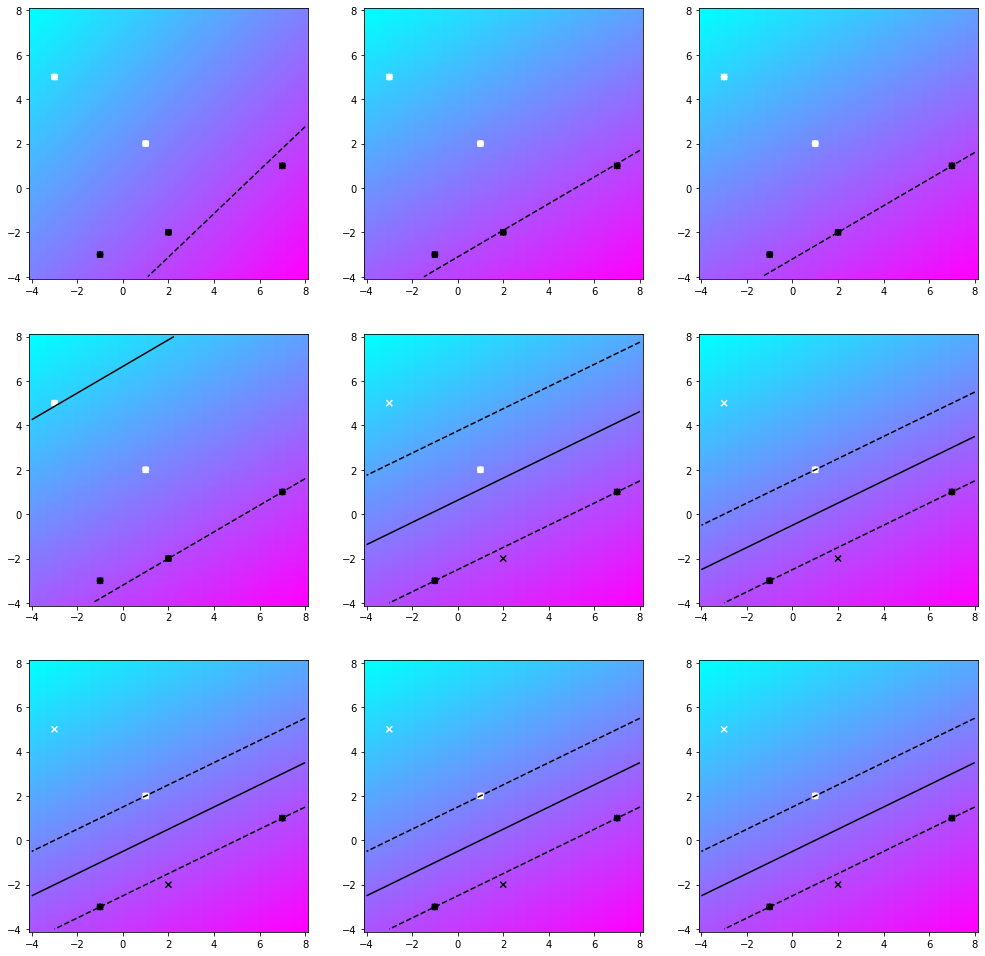

In [10]:
x = np.array([[1,2], [-3,5],[7,1],[2,-2],[-1,-3]])
y = np.array([-1,-1,1,1,1])

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(17, 17))

i = 0
for C in np.logspace(-5, 3, 9):
    lin_svm = LinearSVM(C)
    lin_svm.fit(x, y)
    lin_svm.draw_results(ax[i // 3][i % 3], x, y)
    i = i + 1

если штрафы нулевые, то задача линейно разделима
y = 1, -1


In [14]:
from sklearn.datasets import make_classification

Text(0.5, 1.0, 'Плохо разделимые классы')

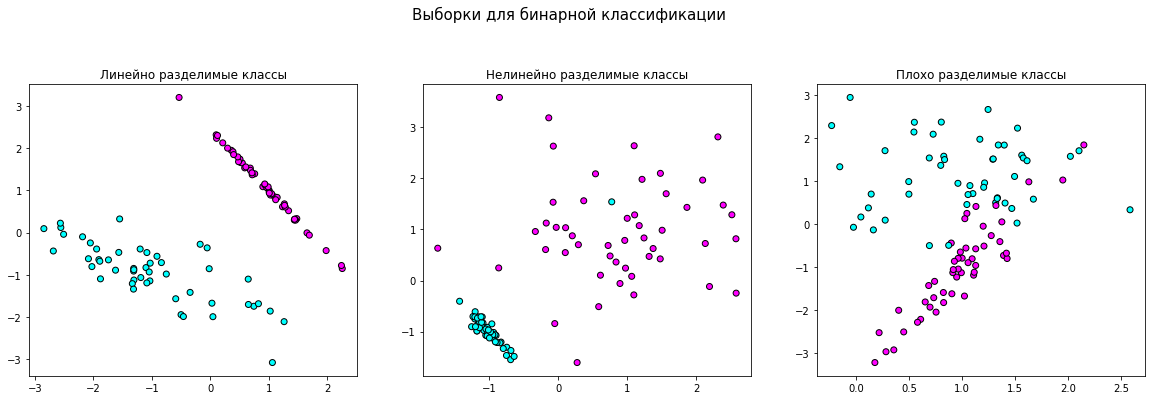

In [15]:
lin_sep_X,    lin_sep_y    = make_classification(random_state=16,  n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1)
nonlin_sep_X, nonlin_sep_y = make_classification(random_state=6,   n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1)
bad_sep_X,    bad_sep_y    = make_classification(random_state=116, n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1)

lin_sep_y[lin_sep_y == 0] = -1
nonlin_sep_y[nonlin_sep_y == 0] = -1
bad_sep_y[bad_sep_y == 0] = -1

fig, ax = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Выборки для бинарной классификации', fontsize=15)
plt.subplots_adjust(top=0.8)

ax[0].scatter(lin_sep_X[:, 0],    lin_sep_X[:, 1],    c=lin_sep_y,    cmap='cool', edgecolor='black')
ax[1].scatter(nonlin_sep_X[:, 0], nonlin_sep_X[:, 1], c=nonlin_sep_y, cmap='cool', edgecolor='black')
ax[2].scatter(bad_sep_X[:, 0],    bad_sep_X[:, 1],    c=bad_sep_y,    cmap='cool', edgecolor='black')

ax[0].set_title('Линейно разделимые классы')
ax[1].set_title('Нелинейно разделимые классы')
ax[2].set_title('Плохо разделимые классы')

Классификаторы с различным значением параметра  𝐶 :

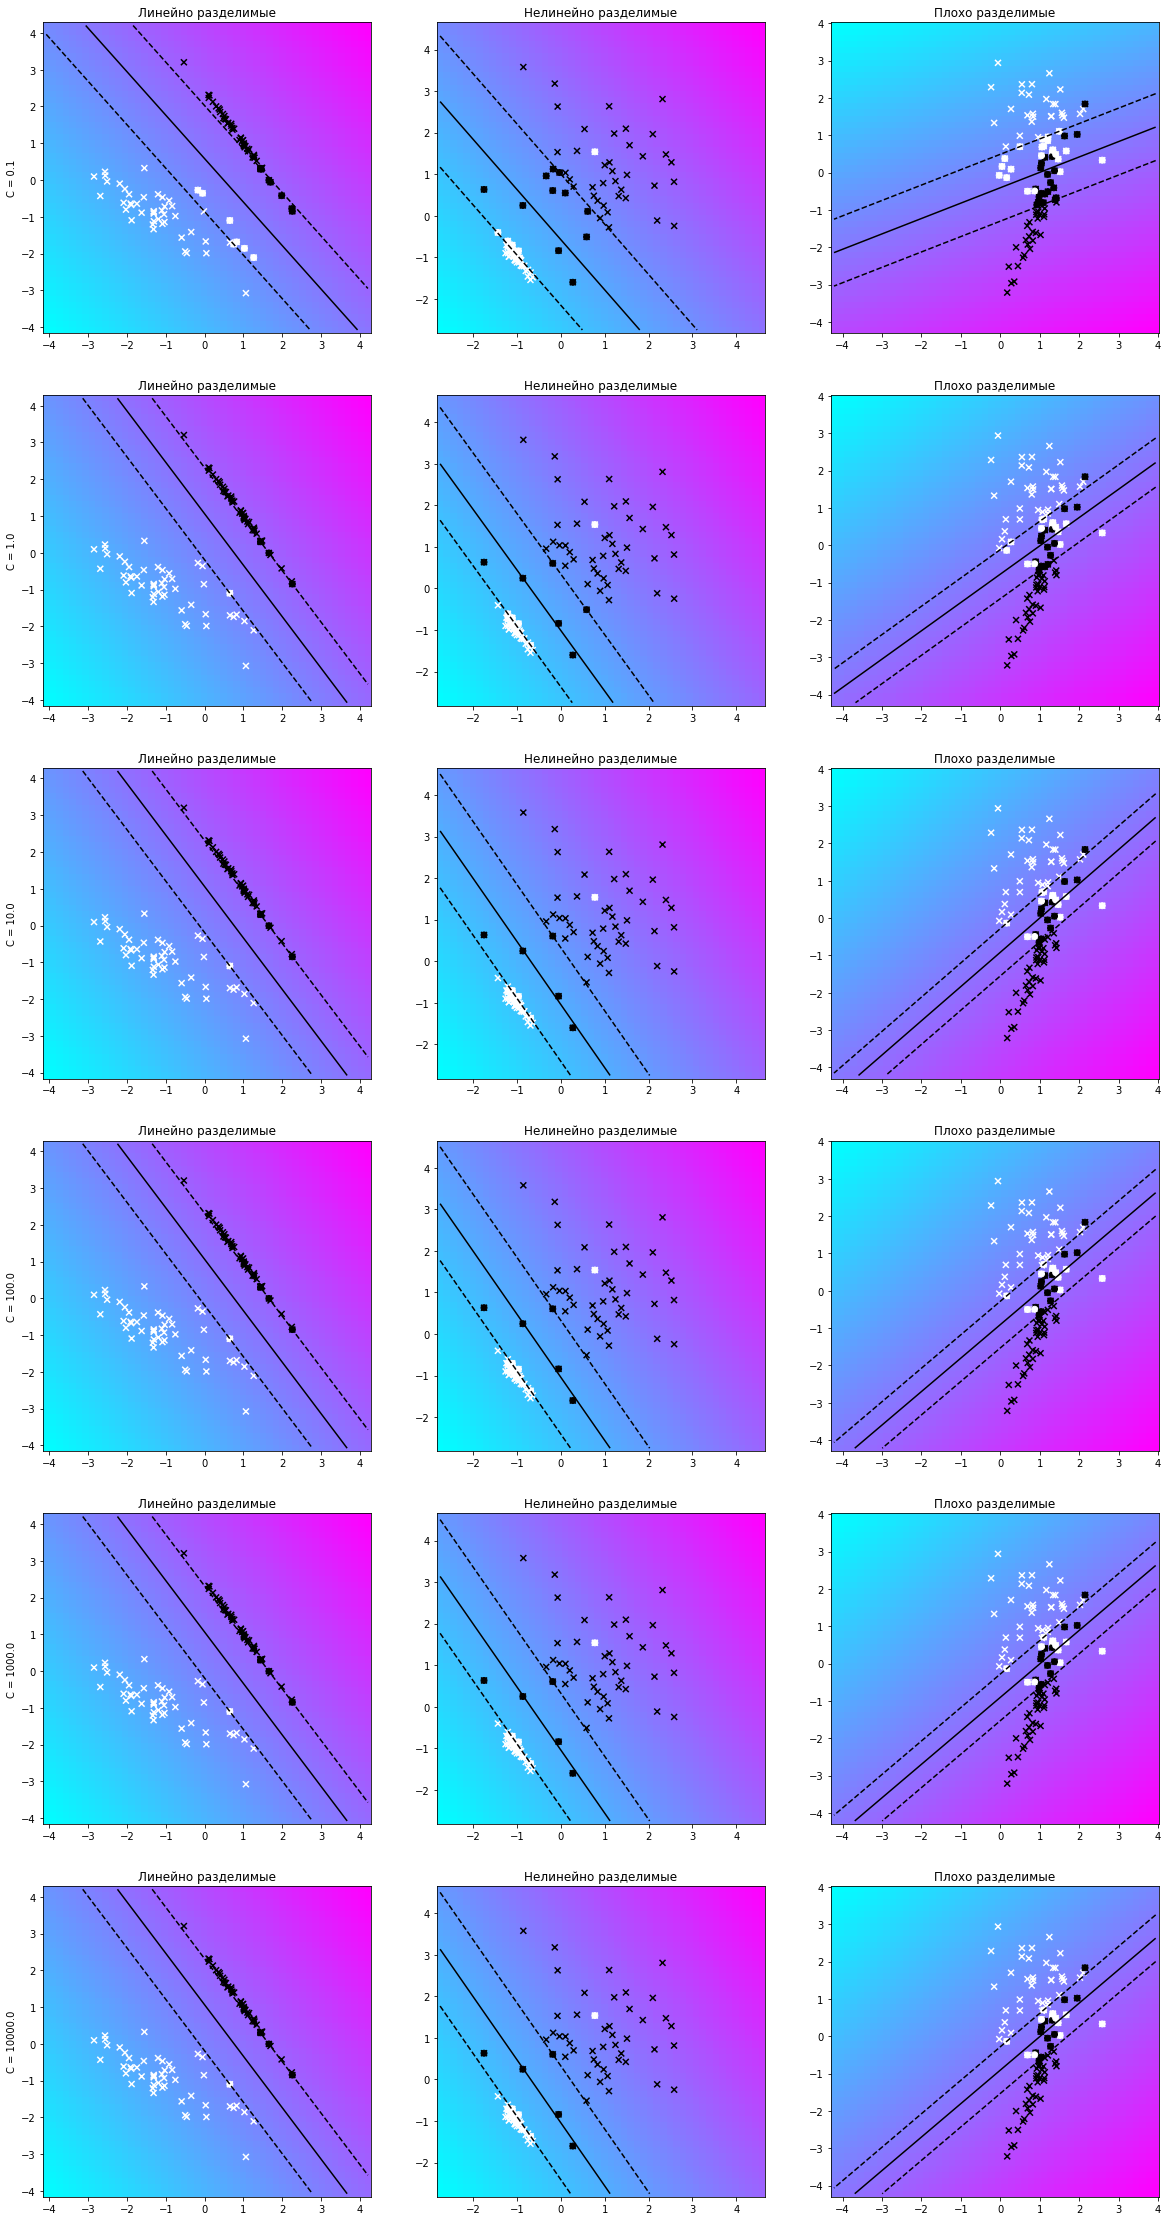

In [13]:
fig, ax = plt.subplots(ncols=3, nrows=6, figsize=(20, 40))

for i, C in enumerate(np.logspace(-1, 4, 6)):
    ax[i][0].set_ylabel(f'C = {C}')
    
    lin_svm1 = LinearSVM(C)
    lin_svm1.fit(lin_sep_X, lin_sep_y)    
    lin_svm1.draw_results(ax[i][0], lin_sep_X, lin_sep_y)
    ax[i][0].set_title('Линейно разделимые')
    
    lin_svm2 = LinearSVM(C)
    lin_svm2.fit(nonlin_sep_X, nonlin_sep_y)    
    lin_svm2.draw_results(ax[i][1], nonlin_sep_X, nonlin_sep_y)
    ax[i][1].set_title('Нелинейно разделимые')
    
    lin_svm3 = LinearSVM(C)
    lin_svm3.fit(bad_sep_X, bad_sep_y)    
    lin_svm3.draw_results(ax[i][2], bad_sep_X, bad_sep_y)
    ax[i][2].set_title('Плохо разделимые')

С = 10 как будто бы оптимальный. 

Как зависит число опорных векторов от параметра  𝐶  для различных выборок?

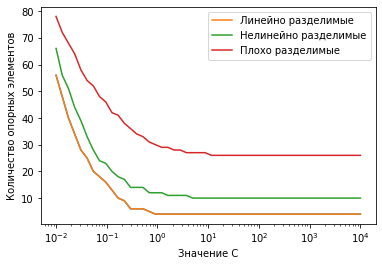

In [68]:
xs = []
ys = []

for i, C in enumerate(np.logspace(-2, 4, 50)):
    lin_svm1 = LinearSVM(C)
    lin_svm1.fit(lin_sep_X, lin_sep_y)
    xs.append(C)
    ys.append(lin_svm1.support_count())
    
plt.xscale('log')
plt.plot(xs, ys)
plt.plot(xs, ys, label='Линейно разделимые')

xs = []
ys = []

for i, C in enumerate(np.logspace(-2, 4, 50)):
    lin_svm1 = LinearSVM(C)
    lin_svm1.fit(nonlin_sep_X, nonlin_sep_y)
    xs.append(C)
    ys.append(lin_svm1.support_count())
    
plt.xscale('log')
plt.plot(xs, ys, label='Нелинейно разделимые')

xs = []
ys = []

for i, C in enumerate(np.logspace(-2, 4, 50)):
    lin_svm1 = LinearSVM(C)
    lin_svm1.fit(bad_sep_X, bad_sep_y)
    xs.append(C)
    ys.append(lin_svm1.support_count())
    
plt.xscale('log')
plt.plot(xs, ys, label='Плохо разделимые')
plt.xlabel('Значение C')
plt.ylabel('Количество опорных элементов')
plt.legend()

С = 10 как будто бы оптимальный снова.

Используя явное преобразование признаков обучим методом опорных векторов квадратичную разделяющую поверхность.

In [69]:
def transform(X):
    result = X.copy()
    
    result = np.append(X, (X[:,0]**2)[:,None], 1)
    result = np.append(X, (X[:,0]*X[:,1])[:,None], 1)
    result = np.append(X, (X[:,0]*X[:,1])[:,None], 1)
    result = np.append(X, (X[:,1]**2)[:,None], 1)
    
    return result

Text(0.5, 1.0, 'Плохо разделимые')

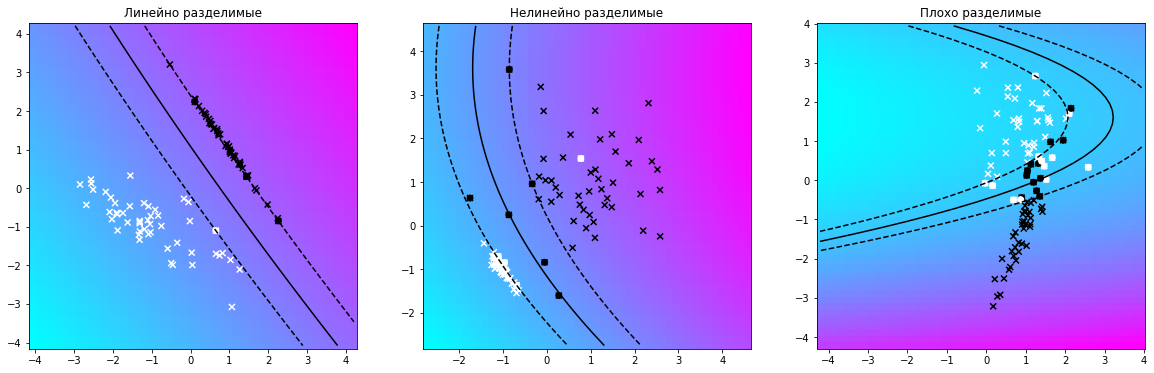

In [77]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(20, 6))
C = 10

lin_svm1 = LinearSVM(C, transform=transform)
lin_svm1.fit(lin_sep_X, lin_sep_y)    
lin_svm1.draw_results(ax[0], lin_sep_X, lin_sep_y)
ax[0].set_title('Линейно разделимые')

lin_svm2 = LinearSVM(C, transform=transform)
lin_svm2.fit(nonlin_sep_X, nonlin_sep_y)    
lin_svm2.draw_results(ax[1], nonlin_sep_X, nonlin_sep_y)
ax[1].set_title('Нелинейно разделимые')

lin_svm3 = LinearSVM(C, transform=transform)
lin_svm3.fit(bad_sep_X, bad_sep_y)    
lin_svm3.draw_results(ax[2], bad_sep_X, bad_sep_y)
ax[2].set_title('Плохо разделимые')

# 3. Двойственный переход и Ядровой SVM

Задачу обучения линейного SVM, рассмотренную в предыдущем пункте принято называть _прямой_ оптимизационной задачей для SVM. Любая задача оптимизации с ограничениями имеет [_двойственную_ задачу Лагранжа](http://goo.gl/OujTPr), в которой оптимизируются _двойственные переменные_ (множители Лагранжа), соответствующие штрафу за нарушение ограничений, максимизируется нижняя оценка функционала прямой задачи. В случае задачи квадратичного программирования, решение двойственной задачи (значение оптимизируемого функционала) совпадает с оптимумом прямой задачи.

Подробнее можно почитать в [статье](./SMAIS11_SVM.pdf).

Двойственная задача для SVM имеет вид:
$$
\begin{gather}
    \sum_{n} \alpha_n - \frac{1}{2}\sum_{n}\sum_{n'} \alpha_{n}\alpha_{n'} y_{n}y_{n'} x_{n}^Tx_{n'} \to \max_{\alpha} \\
    \begin{aligned}
        \text{s.t. } \quad  
        & 0 \le \alpha_n \le C, \quad \forall n = 1, \dots, N \\
        & \sum_{n} \alpha_n y_n = 0
    \end{aligned}
\end{gather}
$$

Оптимизируется вектор из двойственных переменных $\alpha_n$, соответствующих объектам обучающей выборки. Объект $x_n$ является опорным, если $\alpha_n > 0$.

Предсказание вычисляется по следующему правилу:
$$\hat{y}(x) = \text{sign}\left(\sum_{n}\alpha_{n}y_{n}x^Tx_{n} + b\right).$$

Для предсказания необходимо оценить значение $b$. Известно, что для любого опорного объекта, который классифицируется безошибочно верно:
$$y_n = \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'} + b,$$
значит для любого такого объекта:
$$b = y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}.$$

В случае наличия ошибок классификации обучающей выборки, предлагается усреднять значение $b$ по всем опорным векторам:
$$b = \frac{1}{N_\text{SV}}\sum_{n \in \text{SV}}\left(y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}\right).$$
Интуиция здесь такова, что суммарные ошибки в положительную сторону примерно равны суммарным ошибкам в отрицательную сторону.

Другой вариант — отказаться от параметра $b$ и работать с моделью $f(x) = w^Tx$, добавив к вектору $x$ константный признак.

#### Неявное преобразование признаков
Отметим, что двойственная задача SVM содержит вектора признаков исключительно в виде скалярного произведения $x^Tx'$. Эта особенность позволяет производить неявное преобразование признакового пространства. Вместо вычисления функции $\phi(\boldsymbol x)$, которая может отображать исходные признаки в вектора очень большой размерности, будем вычислять скалярное произведение $k(\boldsymbol x, \boldsymbol x') = \phi(\boldsymbol x)^T\phi(\boldsymbol x')$ называемое _ядром_. 

#### Задание
  1. Реализуйте процедуру обучения ядрового SVM, используя QP-солвер.
  2. Протестируйте на случайных двумерных выборках ядровой SVM. Покажите на плоскости строящиеся разделяющие поверхности, линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Попробуйте следующие ядровые функции:
    - линейная: $k(x, x') = x^Tx'$
    - полиномиальная: $k(x, x') = (x^Tx' + 1)^p$ с различными степенями $p = 2,3,\dots$
    - Гауссовская-RBF: $k(x, x') = \exp(-\frac{1}{2\gamma}\|x - x'\|^2)$
  3. Как ведет себя SVM с полиномиальным ядром в зависимости от параметров $C$ и степени ядра $p$?
  4. Как ведет себя SVM с RBF-ядром в зависимости от параметров $C$ и $\gamma$? Поварьируйте параметры $C$ и $\gamma$ по логарифмической сетке. Какие значения параметров ведут к переобучению, а какие — к слишком грубой модели?

In [46]:
from sklearn.base import BaseEstimator

class KernelSVM(BaseEstimator):
    def __init__(self, C, kernel):
        self.C = C
        self.kernel = kernel
    
    def QP(self, X, y):       
        N = X.shape[0]
        dim = X.shape[1]
            
        P = matrix(np.outer(y, y) * X, tc='d')
        q = matrix(-np.ones(N), tc='d')
        G = matrix(np.vstack((np.eye(N), -np.eye(N))), tc='d')
        h = matrix(np.hstack((self.C * np.ones(N), np.zeros(N))), tc='d')
        A = matrix(y.reshape(1, N), tc='d')  
        b = matrix(0, tc='d')     
        
        sol = solvers.qp(P, q, G, h, A, b)
        self.alphas = np.array(sol['x']).flatten()

        return self.alphas
    
    def fit(self, X, y):
        N = X.shape[0]
        dim = X.shape[1]
        
        X2 = np.empty((N, N))
        for i in range(N):
            for j in range(N):
                X2[i, j] = self.kernel(X[i], X[j])
                
        self.alpha_ = self.QP(X2, y)                        
        self.support_indices_ = np.array([])
        
        # Найдем опорные элементы
        for i in range(len(X)):
            if 0.001 <= self.alpha_[i] and self.alpha_[i] <= self.C:
                self.support_indices_ = np.append(self.support_indices_, i).astype(int)        
                
        self.support_alpha_ = self.alpha_[self.support_indices_]
        self.support_vectors_ = X[self.support_indices_]
        self.support_vectors_class_ = y[self.support_indices_]
        
        M = self.support_count()
        self.support_vectors_transformed = np.empty((M, M))
        for i in range(M):
            for j in range(M):
                self.support_vectors_transformed[i, j] = self.kernel(self.support_vectors_[i, :], self.support_vectors_[j, :])
        
        self.bias_ = np.mean(
            self.support_vectors_class_ - 
            np.sum(np.repeat(self.support_alpha_ * self.support_vectors_class_, M).reshape(M, M).T * self.support_vectors_transformed, axis=1))
    
    def support_count(self):
        return len(self.support_indices_)
    
    def draw_results(self, fig, X, y):        
        fig.scatter(X[:, 0], X[:, 1], c=y, cmap='gist_yarg', marker='x')
        fig.scatter(self.support_vectors_[:, 0], self.support_vectors_[:, 1], c=self.support_vectors_class_, cmap='gist_yarg', marker='o')        
        
        xymin = np.min(X) - 1      
        xymax = np.max(X) + 1
        
        xx, yy = np.meshgrid(np.linspace(xymin, xymax, 50), np.linspace(xymin, xymax, 50))
        
        points = []
        for i in range(len(xx)):
            for j in range(len(xx[i])):
                points.append(np.array([xx[i][j], yy[i][j]]))

        points = np.array(points)
        predictions = self.predict_proba(points)
        zz = np.reshape(predictions, xx.shape)

        # Цветной фон, соответствующий значению решающего правила
        fig.pcolormesh(xx, yy, zz, cmap='cool', zorder=0)

        # Линии уровня и кси-коридор
        fig.contour(xx, yy, zz, levels=(-1, 0, 1), colors='k', linestyles = ['dashed', 'solid', 'dashed'], linewidths=1.5, zorder=1)
        
        # fig.xlim(xymin, xymax)
        # fig.ylim(xymin, xymax)
            
    def predict_proba(self, X):        
        N = X.shape[0]
        M = self.support_count()
        
        X2 = np.empty((M, N))
        for i in range(M):
            for j in range(N):
                X2[i, j] = self.kernel(self.support_vectors_[i, :], X[j, :])
                
        alpha_y = self.support_alpha_ * self.support_vectors_class_
        alpha_y = np.repeat(alpha_y, N).reshape(M, N)
        
        return np.sum(alpha_y * X2, axis = 0) + self.bias_
            
    def predict(self, X):
        return sign(self.predict_proba(X))

In [34]:
power = 2
gamma = 1

def kernel_linear(x, y):
    return np.dot(x, y)

def kernel_polynomial(x, y):
    return (np.dot(x, y) + 1) ** power

def kernel_rbf(x, y):
    return np.exp(-1 / (2 * gamma) * np.linalg.norm(x - y) ** 2)

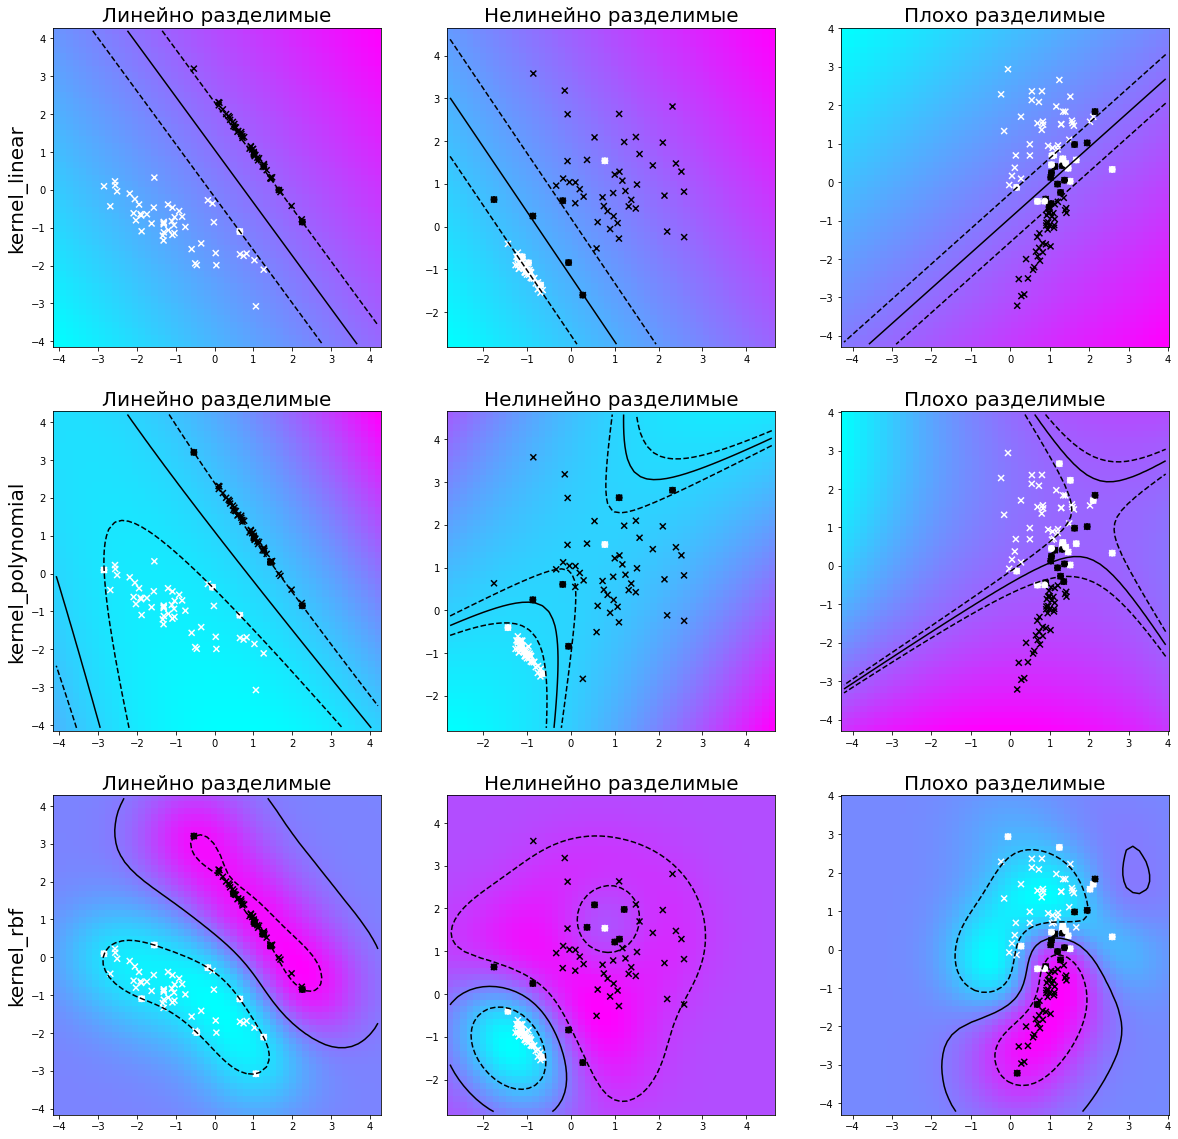

In [35]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(20, 20))
C = 10

for i, kernel in enumerate([kernel_linear, kernel_polynomial, kernel_rbf]):            
    ax[i][0].set_ylabel(kernel.__name__, fontsize=20)
    
    lin_svm1 = KernelSVM(C, kernel)
    lin_svm1.fit(lin_sep_X, lin_sep_y)    
    lin_svm1.draw_results(ax[i][0], lin_sep_X, lin_sep_y)
    ax[i][0].set_title('Линейно разделимые', fontsize=20)

    lin_svm2 = KernelSVM(C, kernel)
    lin_svm2.fit(nonlin_sep_X, nonlin_sep_y)    
    lin_svm2.draw_results(ax[i][1], nonlin_sep_X, nonlin_sep_y)
    ax[i][1].set_title('Нелинейно разделимые', fontsize=20)

    lin_svm3 = KernelSVM(C, kernel)
    lin_svm3.fit(bad_sep_X, bad_sep_y)    
    lin_svm3.draw_results(ax[i][2], bad_sep_X, bad_sep_y)
    ax[i][2].set_title('Плохо разделимые', fontsize=20)

Как ведет себя SVM с полиномиальным ядром в зависимости от параметрa 𝐶 ?

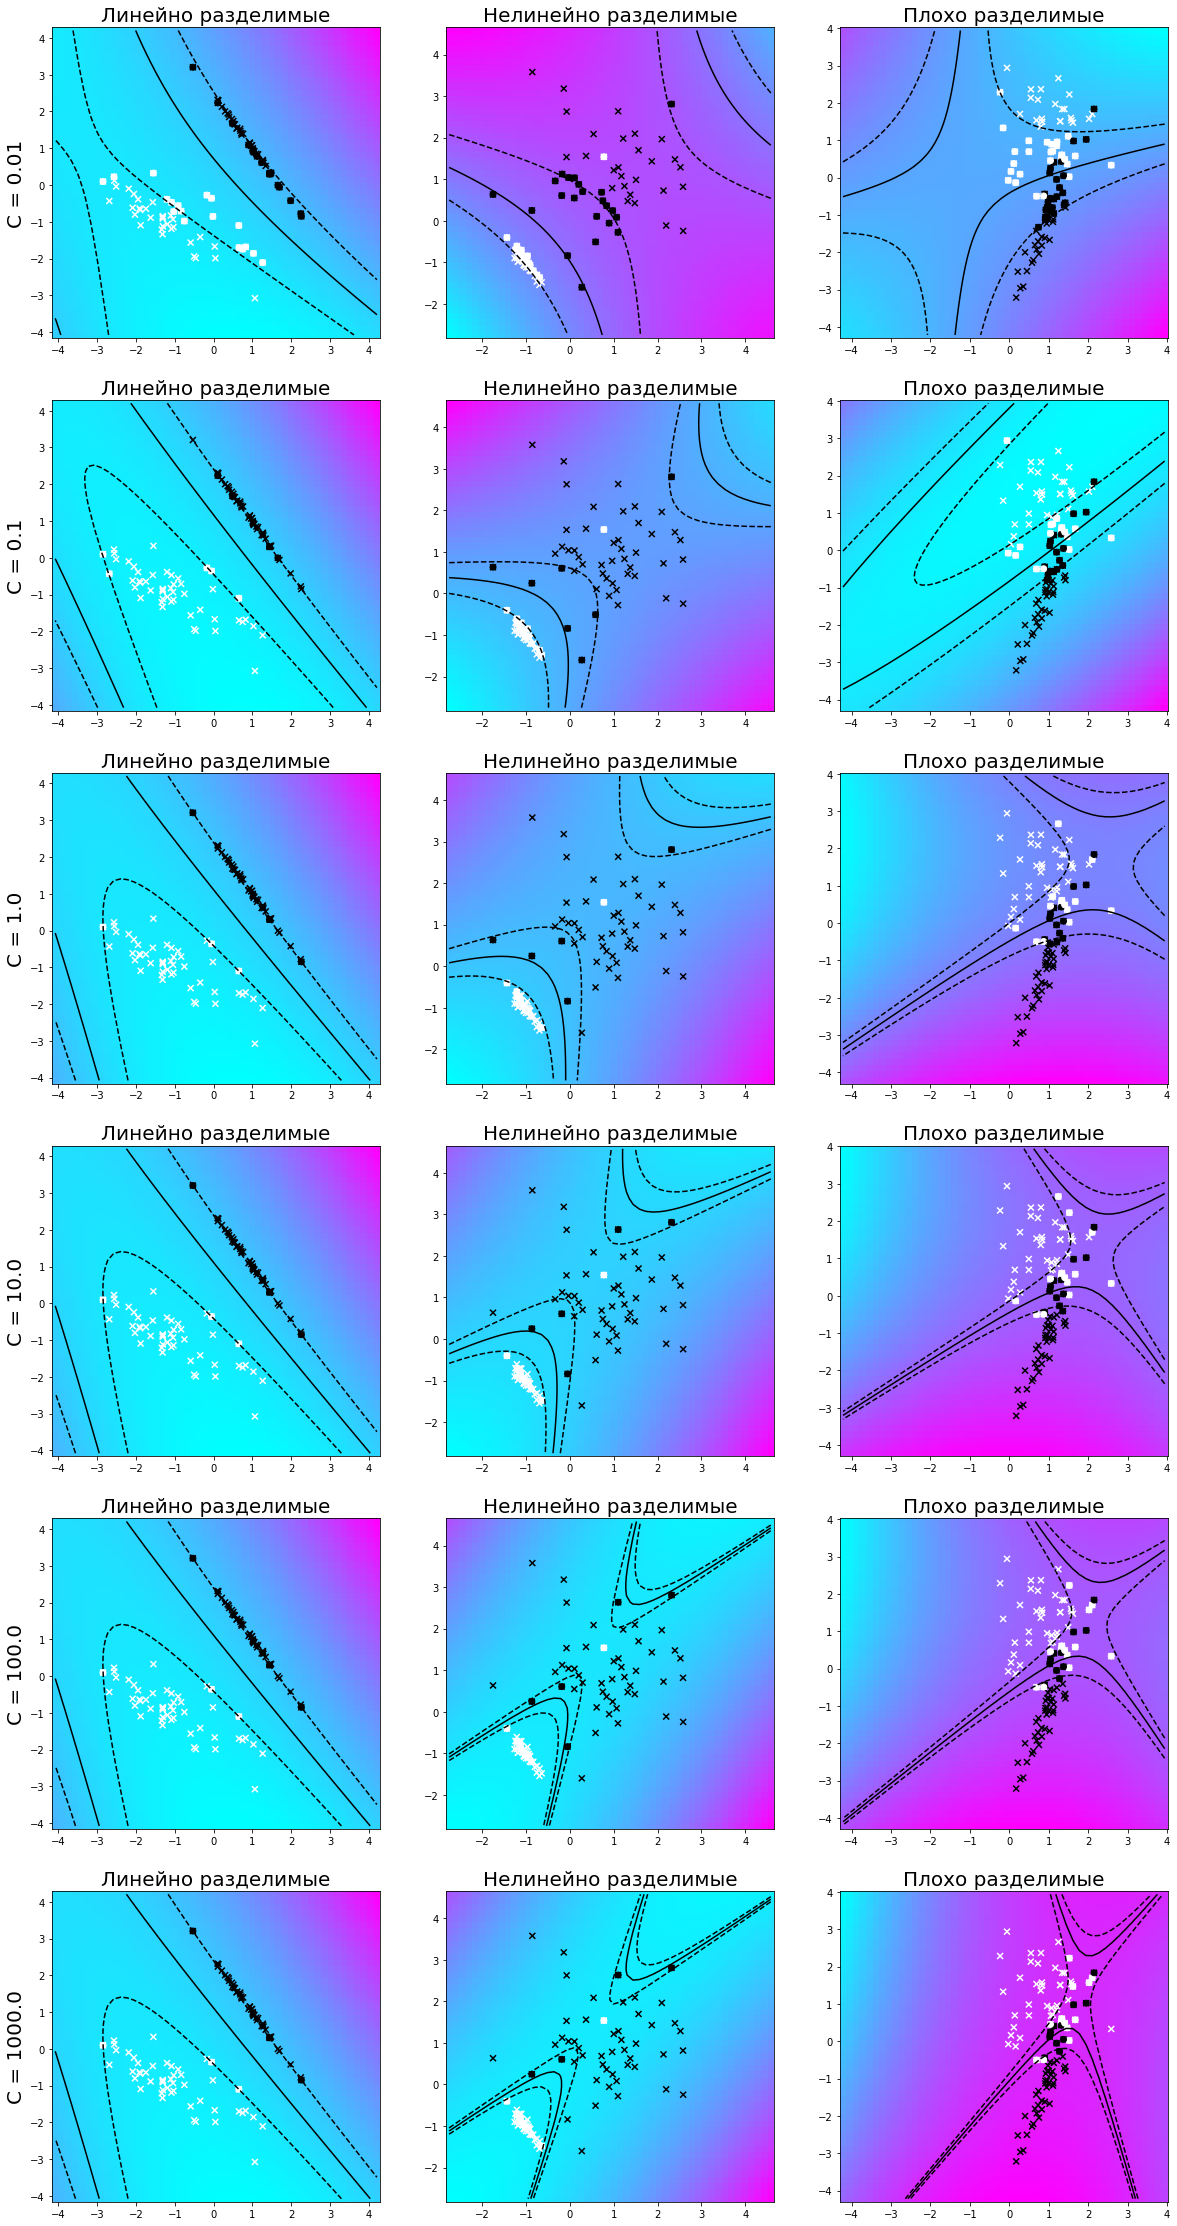

In [42]:
fig, ax = plt.subplots(ncols=3, nrows=6, figsize=(20, 40))

for i, C in enumerate(np.logspace(-2, 3, 6)):
    ax[i][0].set_ylabel(f'C = {C}', fontsize=20)    
    
    lin_svm1 = KernelSVM(C, kernel_polynomial)
    lin_svm1.fit(lin_sep_X, lin_sep_y)    
    lin_svm1.draw_results(ax[i][0], lin_sep_X, lin_sep_y)
    ax[i][0].set_title('Линейно разделимые', fontsize=20)

    lin_svm2 = KernelSVM(C, kernel_polynomial)
    lin_svm2.fit(nonlin_sep_X, nonlin_sep_y)    
    lin_svm2.draw_results(ax[i][1], nonlin_sep_X, nonlin_sep_y)
    ax[i][1].set_title('Нелинейно разделимые', fontsize=20)

    lin_svm3 = KernelSVM(C, kernel_polynomial)
    lin_svm3.fit(bad_sep_X, bad_sep_y)    
    lin_svm3.draw_results(ax[i][2], bad_sep_X, bad_sep_y)
    ax[i][2].set_title('Плохо разделимые', fontsize=20)

Маленький С - плохое разделение, большой - тоже. Истина где-то посередине.

Как ведет себя SVM с полиномиальным ядром в зависимости от степени ядра  𝑝 ?

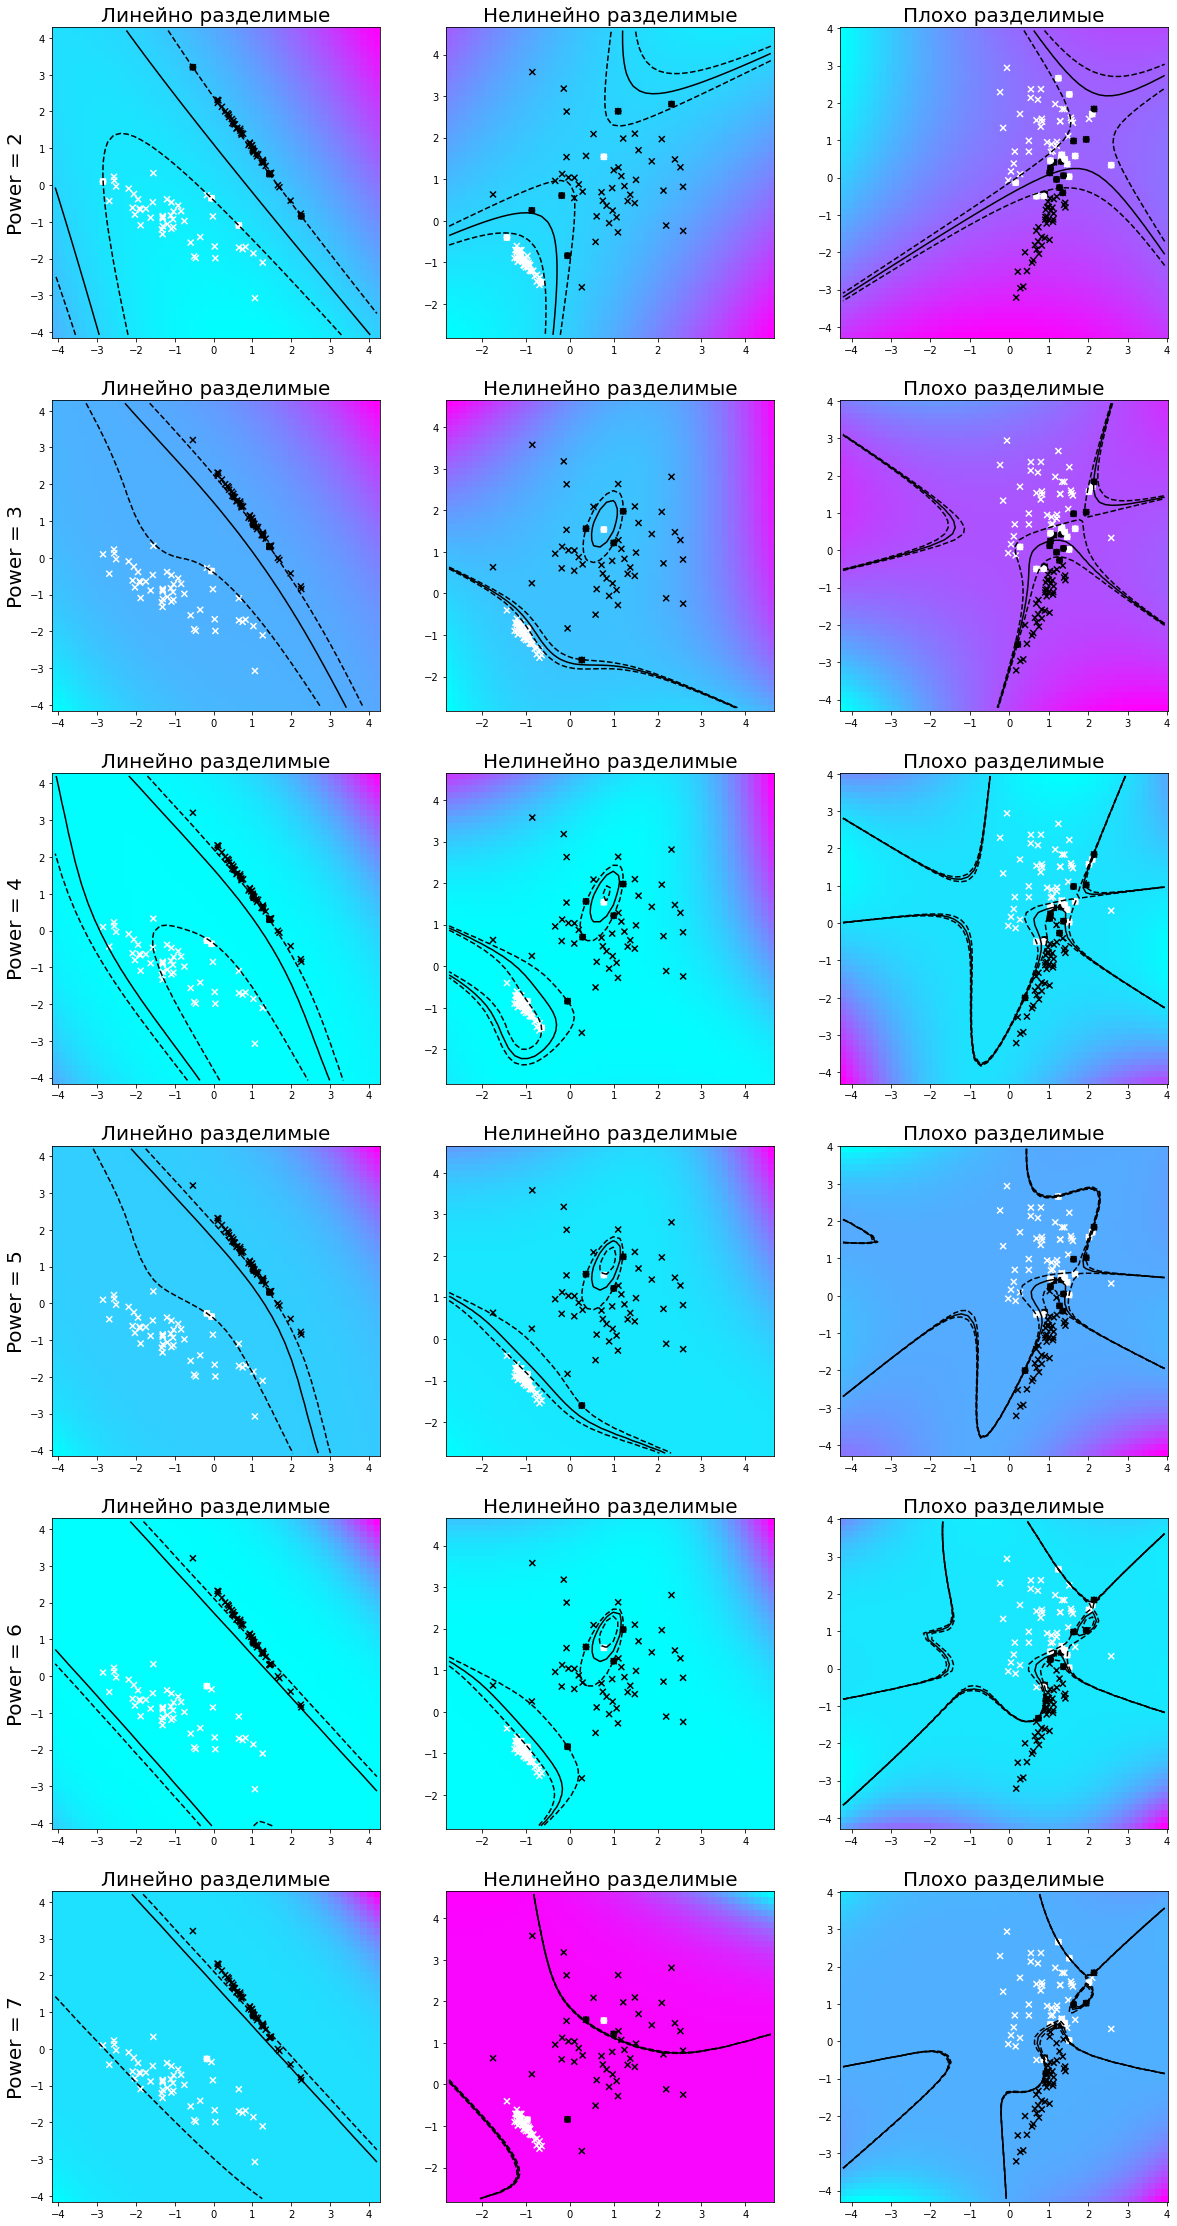

In [49]:
fig, ax = plt.subplots(ncols=3, nrows=6, figsize=(20, 40))
C = 10

for i, p in enumerate([2, 3, 4, 5, 6, 7]):
    power = p
    ax[i][0].set_ylabel(f'Power = {p}', fontsize=20)
    
    lin_svm1 = KernelSVM(C, kernel_polynomial)
    lin_svm1.fit(lin_sep_X, lin_sep_y)    
    lin_svm1.draw_results(ax[i][0], lin_sep_X, lin_sep_y)
    ax[i][0].set_title('Линейно разделимые', fontsize=20)

    lin_svm2 = KernelSVM(C, kernel_polynomial)
    lin_svm2.fit(nonlin_sep_X, nonlin_sep_y)    
    lin_svm2.draw_results(ax[i][1], nonlin_sep_X, nonlin_sep_y)
    ax[i][1].set_title('Нелинейно разделимые', fontsize=20)

    lin_svm3 = KernelSVM(C, kernel_polynomial)
    lin_svm3.fit(bad_sep_X, bad_sep_y)    
    lin_svm3.draw_results(ax[i][2], bad_sep_X, bad_sep_y)
    ax[i][2].set_title('Плохо разделимые', fontsize=20)

Чем больше р, тем страшнее. р=3 - мой личный фаворит(субъективно)

Как ведет себя SVM с RBF-ядром в зависимости от параметрa  𝐶 ?

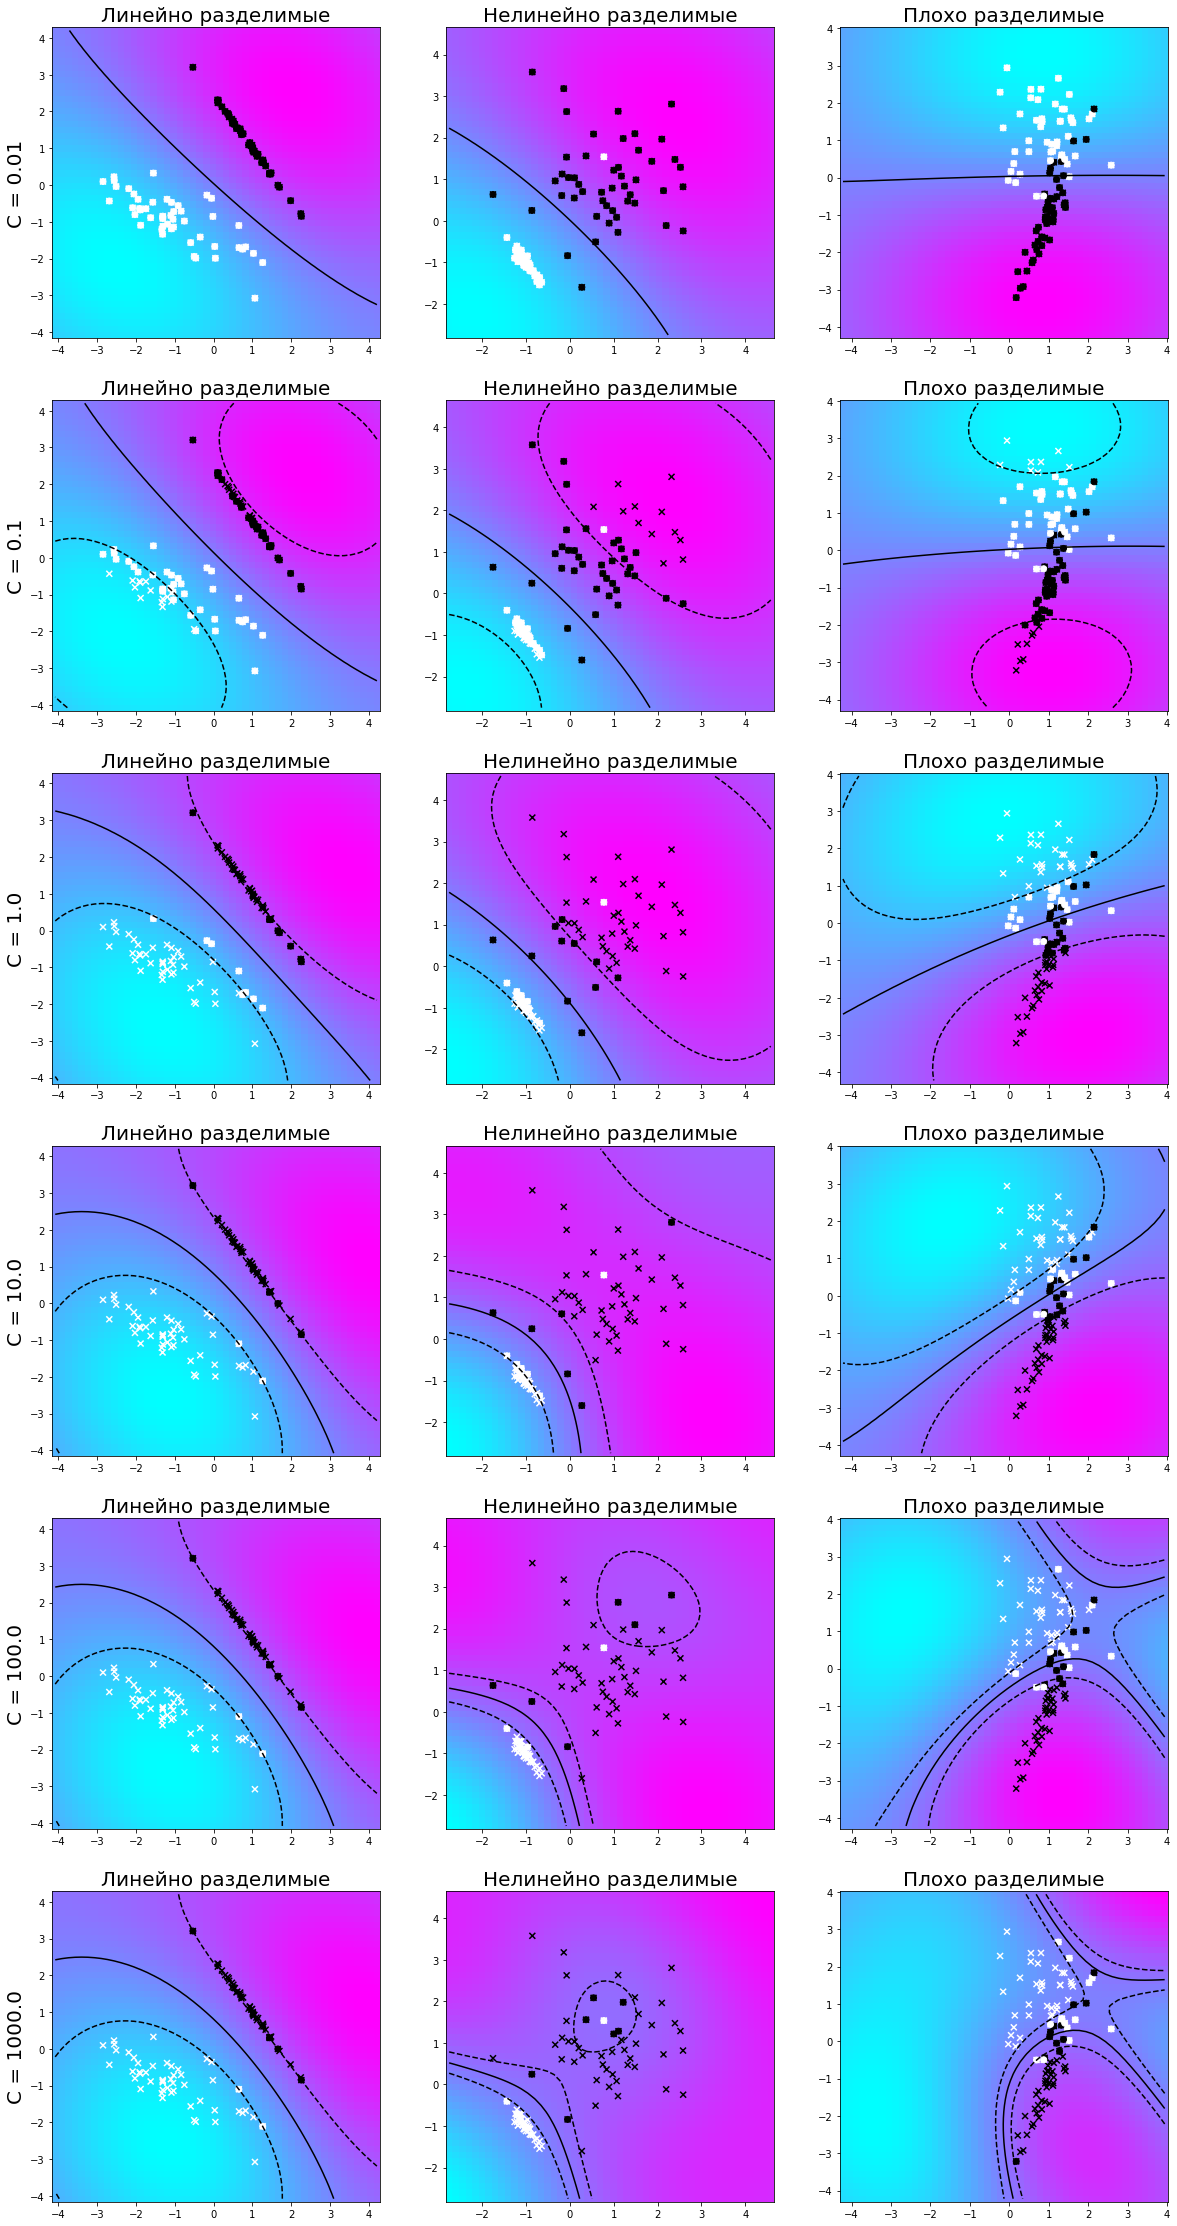

In [79]:
fig, ax = plt.subplots(ncols=3, nrows=6, figsize=(20, 40))
gamma = 10
for i, C in enumerate(np.logspace(-2, 3, 6)):
    ax[i][0].set_ylabel(f'C = {C}', fontsize=20)    
    
    lin_svm1 = KernelSVM(C, kernel_rbf)
    lin_svm1.fit(lin_sep_X, lin_sep_y)    
    lin_svm1.draw_results(ax[i][0], lin_sep_X, lin_sep_y)
    ax[i][0].set_title('Линейно разделимые', fontsize=20)

    lin_svm2 = KernelSVM(C, kernel_rbf)
    lin_svm2.fit(nonlin_sep_X, nonlin_sep_y)    
    lin_svm2.draw_results(ax[i][1], nonlin_sep_X, nonlin_sep_y)
    ax[i][1].set_title('Нелинейно разделимые', fontsize=20)

    lin_svm3 = KernelSVM(C, kernel_rbf)
    lin_svm3.fit(bad_sep_X, bad_sep_y)    
    lin_svm3.draw_results(ax[i][2], bad_sep_X, bad_sep_y)
    ax[i][2].set_title('Плохо разделимые', fontsize=20)

не вижу переобучения. С = 100 мой фаворит.

Как ведет себя SVM с RBF-ядром в зависимости от параметра  𝛾 ? 

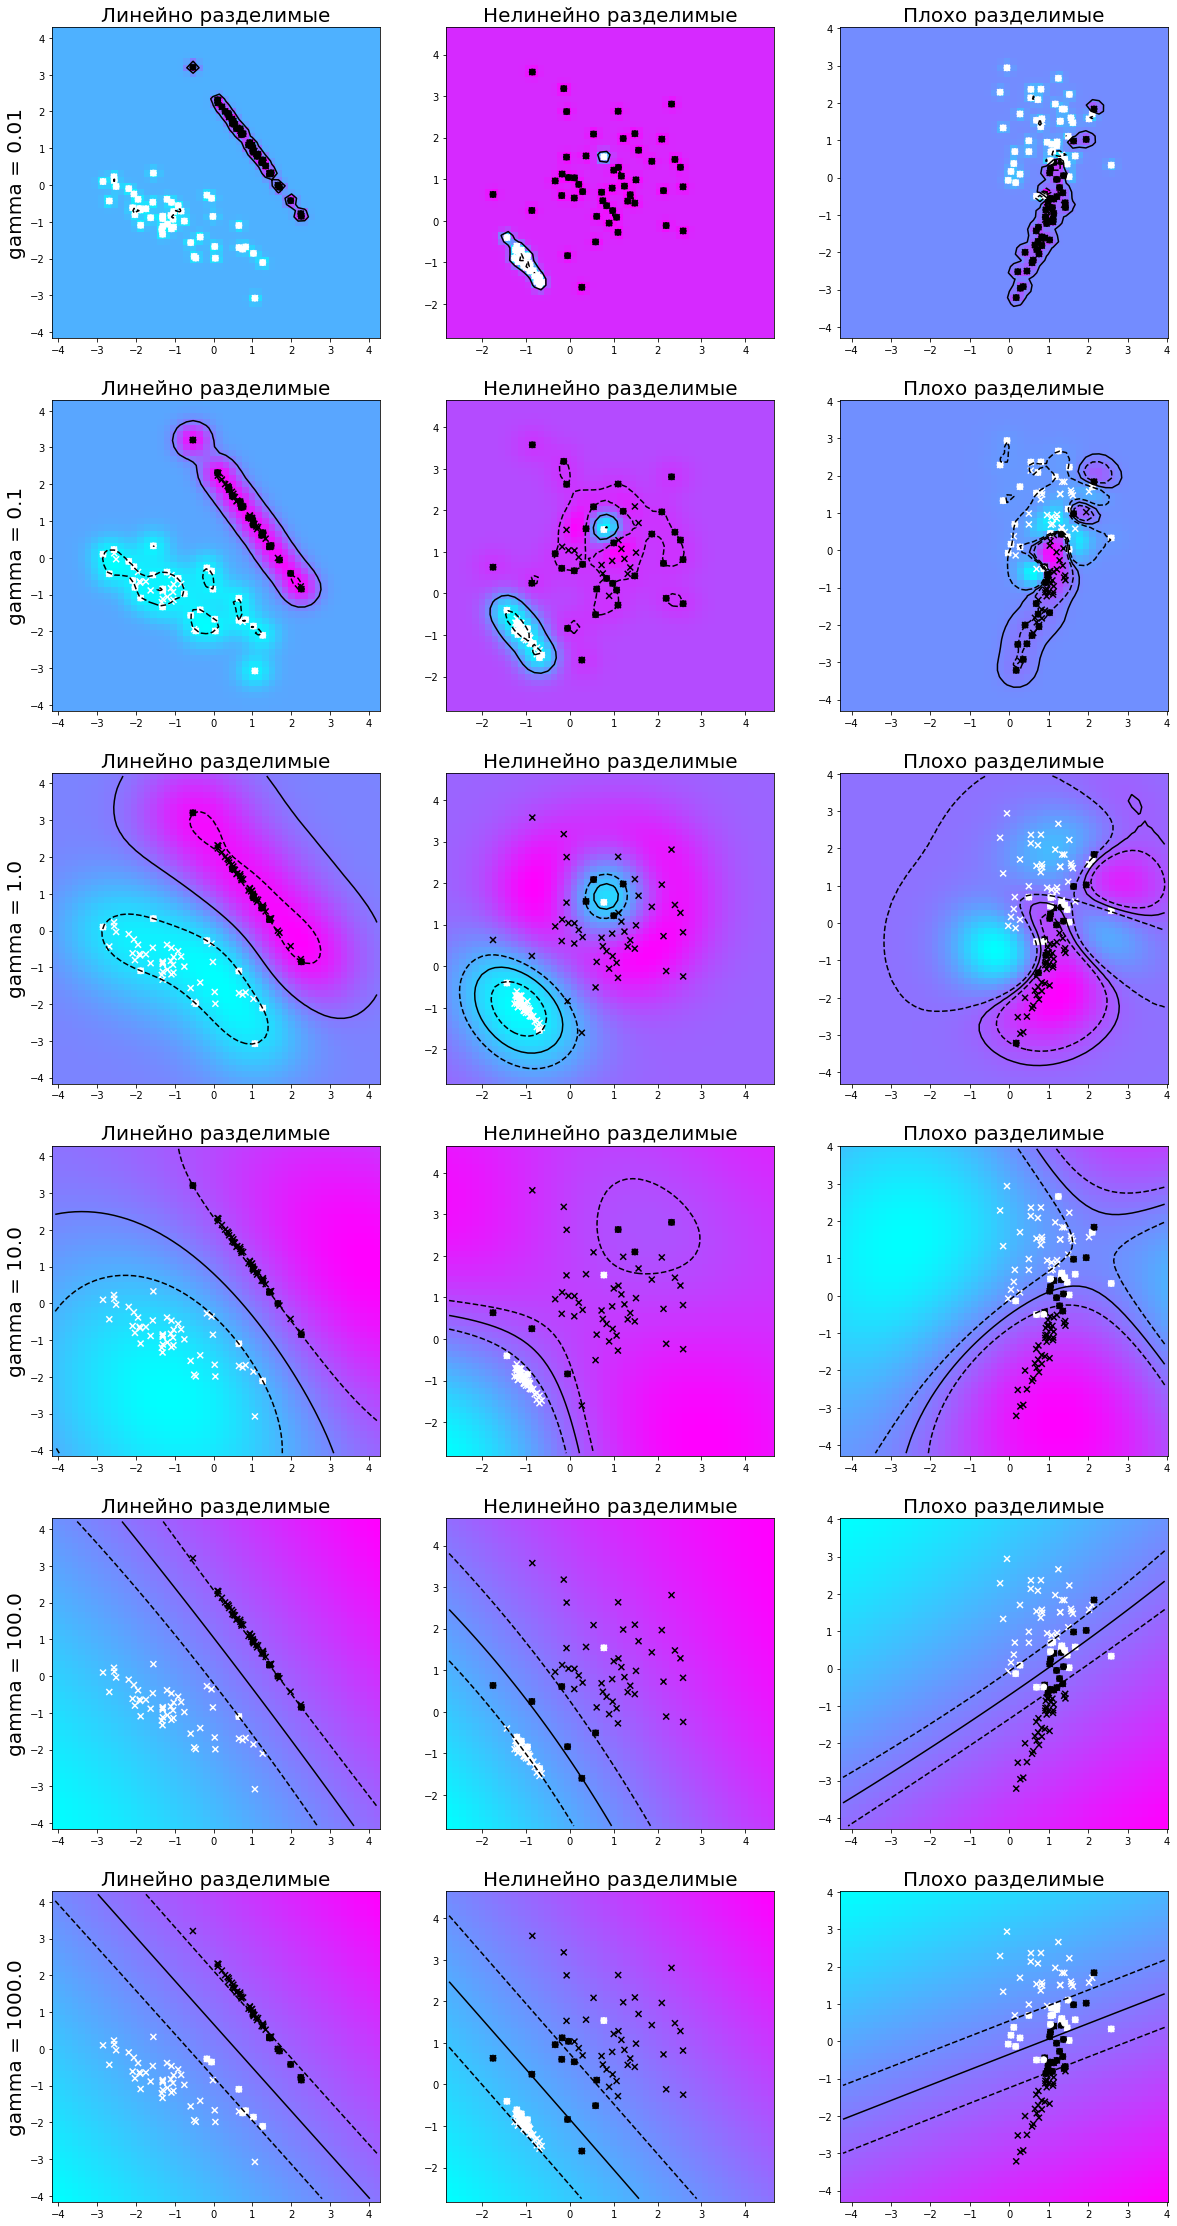

In [55]:
fig, ax = plt.subplots(ncols=3, nrows=6, figsize=(20, 40))
C = 100

for i, g in enumerate(np.logspace(-2, 3, 6)):
    gamma = g
    ax[i][0].set_ylabel(f'gamma = {g}', fontsize=20)
    
    lin_svm1 = KernelSVM(C, kernel_rbf)
    lin_svm1.fit(lin_sep_X, lin_sep_y)    
    lin_svm1.draw_results(ax[i][0], lin_sep_X, lin_sep_y)
    ax[i][0].set_title('Линейно разделимые', fontsize=20)

    lin_svm2 = KernelSVM(C, kernel_rbf)
    lin_svm2.fit(nonlin_sep_X, nonlin_sep_y)    
    lin_svm2.draw_results(ax[i][1], nonlin_sep_X, nonlin_sep_y)
    ax[i][1].set_title('Нелинейно разделимые', fontsize=20)

    lin_svm3 = KernelSVM(C, kernel_rbf)
    lin_svm3.fit(bad_sep_X, bad_sep_y)    
    lin_svm3.draw_results(ax[i][2], bad_sep_X, bad_sep_y)
    ax[i][2].set_title('Плохо разделимые', fontsize=20)

При большом гамма ведет себя как линейный классификатор. А малые гамма ведут к переобучению.